In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
TARGET_YIELD = 1200.0
TOP_N = 5
CSV_PATH = "../outputs/suggestions_y1200.csv"  # from generate.py
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
def make_alloy_formula(row):
    elements = ["Al", "Co", "Cr", "Hf", "Mo", "Nb", "Si", "Ta", "Ti", "V", "W", "Zr"]
    frac_cols = [f"{el}_frac" for el in elements]

    # Normalize fractions so they sum exactly to 1
    total = row[frac_cols].sum()
    formula_parts = []
    for el in elements:
        frac = row[f"{el}_frac"] / total
        frac = round(frac, 2)
        if frac > 0:
            if abs(frac - 1) < 1e-2:
                formula_parts.append(f"{el}")
            else:
                formula_parts.append(f"{el}{frac}")
    return "".join(formula_parts)

In [4]:
df = pd.read_csv(CSV_PATH)

# Add alloy formula column
df["Alloy_Formula"] = df.apply(make_alloy_formula, axis=1)

# Sort by closeness to target
df_sorted = df.iloc[(df["Predicted_Yield_Strength"] - TARGET_YIELD).abs().argsort()]

# Pick top N
df_top = df_sorted.head(TOP_N).reset_index(drop=True)

# Save top N to outputs
top_csv_path = OUT_DIR / f"top_{TOP_N}_alloys_y{int(TARGET_YIELD)}.csv"
df_top.to_csv(top_csv_path, index=False)

print(f"[INFO] Saved top {TOP_N} alloys to {top_csv_path}")

[INFO] Saved top 5 alloys to ../outputs/top_5_alloys_y1200.csv


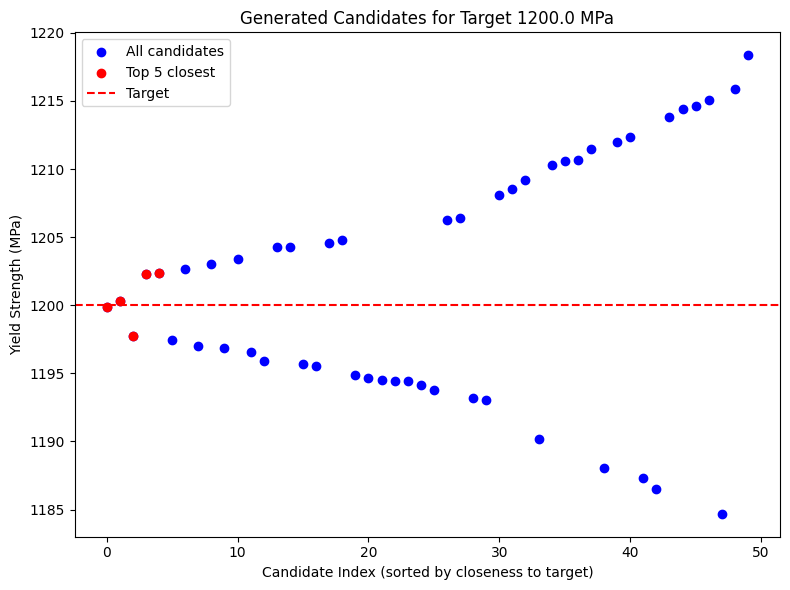

[INFO] Plot saved to ../outputs/plot_y1200_top5.png

Top alloys closest to target:
   Predicted_Yield_Strength                                      Alloy_Formula
0                 1199.8333  Al0.07Hf0.05Mo0.09Nb0.21Si0.01Ta0.09Ti0.22V0.1...
1                 1200.2815  Al0.06Hf0.05Mo0.09Nb0.21Si0.01Ta0.09Ti0.22V0.1...
2                 1197.7180  Al0.06Hf0.05Mo0.09Nb0.21Si0.01Ta0.09Ti0.22V0.1...
3                 1202.3242  Al0.07Cr0.01Hf0.05Mo0.09Nb0.21Si0.01Ta0.09Ti0....
4                 1202.3700  Al0.06Hf0.05Mo0.1Nb0.21Si0.01Ta0.09Ti0.22V0.11...


In [5]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(df_sorted)), df_sorted["Predicted_Yield_Strength"],
            color='blue', label="All candidates")
plt.scatter(df_top.index, df_top["Predicted_Yield_Strength"],
            color='red', label=f"Top {TOP_N} closest")
plt.axhline(y=TARGET_YIELD, color='r', linestyle='--', label='Target')

plt.xlabel("Candidate Index (sorted by closeness to target)")
plt.ylabel("Yield Strength (MPa)")
plt.title(f"Generated Candidates for Target {TARGET_YIELD} MPa")
plt.legend()
plt.tight_layout()

plot_path = OUT_DIR / f"plot_y{int(TARGET_YIELD)}_top{TOP_N}.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"[INFO] Plot saved to {plot_path}")
print("\nTop alloys closest to target:")
print(df_top[["Predicted_Yield_Strength", "Alloy_Formula"]])